# Using JASPAR Deep Learning Models with tangermeme

This notebook demonstrates how to use JASPAR’s deep learning collection
for TF binding prediction, motif discovery, and sequence analysis
via the `tangermeme` Python library.

In [1]:
# Install requirements
!pip install --quiet "tangermeme==1.0.0"
!pip install --quiet "bpnet-lite==0.9.5"

The `download_jaspar_model` function provides a clean and reproducible way to fetch **JASPAR Deep Learning models** directly from the official JASPAR server. Instead of manually running `wget` for each transcription factor, this function
lets you simply provide a model ID (e.g., **`BPXXXXXX.Y`**) and it will:

- Construct the correct download URL  
- Retrieve the corresponding `.h5` model file  
- Save it in a local `models/` directory  
- Return the full file path for easy loading in downstream analyses  

In [2]:
# Download a DL model with JASPAR ID
import os
import requests

def download_jaspar_model(model_id: str, base_url: str = None, dest_dir: str = "models"):
    """
    Download a JASPAR Deep Learning model (.h5) given its ID
    (e.g., BP000001.1) and return the local file path.

    Parameters
    ----------
    model_id : str
        JASPAR DL model ID, e.g. "BP000001.1".
    base_url : str
        Base URL to the year-specific JASPAR DL directory.
        If None, defaults to JASPAR 2026 models.
    dest_dir : str
        Local directory to store downloaded models.

    Returns
    -------
    str
        Path to the downloaded model file.
    """
    if base_url is None:
        base_url = "https://mencius.uio.no/JASPAR/JASPAR_DeepLearning/2026/models"

    # Ensure local directory exists
    os.makedirs(dest_dir, exist_ok=True)

    # Construct download URL
    url = f"{base_url}/{model_id}/{model_id}_model.h5"

    # Construct destination path
    local_path = os.path.join(dest_dir, f"{model_id}_model.h5")

    # Skip download if file already exists
    if os.path.exists(local_path):
        print(f"[INFO] Model already downloaded: {local_path}")
        return local_path

    # Download the file
    print(f"[INFO] Downloading {model_id} model from:")
    print(f"       {url}")

    response = requests.get(url, stream=True)

    if response.status_code == 200:
        with open(local_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"[INFO] Model saved to: {local_path}")
    else:
        raise ValueError(f"Failed to download model (HTTP {response.status_code}): {url}")

    return local_path

## Making predictions and assigning contributions
We will work with a DL model trained to
predict **CTCF binding in lung fibroblast cells**. This model is identified in the
JASPAR database by the ID **BP000194.1**. After downloading and loading the model,
we will use it to:

1. **Generate predictions** on DNA sequences of interest.  
2. **Compute attribution/contribution scores** using methods such as **DeepLIFT**
   and **SHAP**, which highlight which nucleotides contribute most to the model’s
   prediction.

In [3]:
model_path = download_jaspar_model("BP000235.1")
print("Model path:", model_path)

[INFO] Model already downloaded: models/BP000235.1_model.h5
Model path: models/BP000235.1_model.h5


In [4]:
from bpnetlite.bpnet import BasePairNet
from bpnetlite.bpnet import ControlWrapper, CountWrapper, ProfileWrapper
from tangermeme.utils import random_one_hot, one_hot_encode
from tangermeme.predict import predict
import torch
from tangermeme.deep_lift_shap import deep_lift_shap
import torch.nn as nn
from tangermeme.ersatz import substitute
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo

To better understand how the model detects CTCF binding signals, we will use a
synthetic **random DNA sequence** with no
biological signal. Then, we **insert a known CTCF motif** into this background
sequence.

In [5]:
sequence = ""

with open("example.fa", "r") as f:
    for line in f:
        if line.startswith(">"):
            continue   # skip header
        sequence += line.strip()

print(sequence)
print("Length:", len(sequence))

CTGTTCCCCTTAATCAACGCTCCGACCGTGCGTCACCCGTTATGCCAATTGTCCCATACCATTGTTAACCATCGATCAACACGACCCGCTTGTCTATGCTAGGACAATTGATACGGATGACTGACTGGTCGTTTTAATCCTTTGTTTATGACATTTATTTGCAGGTATGAATGAGGTCCAGCGTGGCTCTGGCATGACGAAAGCTGACGGACGCTGCCAAGGGTTCTTTGGTCCTCAGTTCTGACCCCGCACGTCAAATCAGTTCCTGATTTAGTGGAGCTGGGCACCTGTCGGTATGTCACCGTCCCATCTCTTTGCGGCAATAAGTCGGAAGATCACGTAACATTGAGGGGATGTATCTGCCAAAGACCAAATCTGAGCCTTGTCTAAGCCCCCAGATAACAGTCACGTAGCTACTTCCAAATATTGAAACGTTATCGGTGCGCTCGACTTTATGTGAAGGAGGTATCCCATGATACTAGCAGGCTGTAAGGGGTCCTAGGCCTAATGCCTTCCATTTTGGGTACGGCCGGGCCGCCTGTAGTCCCAGCGCGGGCCCCATCCATCCGGCACGGAGCAAGCGCGTGCGTGGGTTTTTAAGGTTCCTAAGCCGCCTGCCTAACGTCCTAGCGAGCCTAACCAGCCTCCGCTCCCGCGTCGCCGGTCAACTGGTTTGAGCACGAAGCTTGGCTACTTACGAGGTTATCTCATAATGAAGGGTAGGCATGTGATATTATCATGCTAGAGCAAGTGTATGTCAACCGGATTAGCTCAGTCGGAATAACGTGCCCCCTAGACCGTTCAAATGGACACCGCAGTGGTCTCTTTGTCTACGAGACCTCCTGTACTACTCGTTATGCAAGTTCAATTCCGCGGTGGATTATTGGAGGGCTGTCAAATCATATCGAGGGTTAAAGTCTCTCATGGATGTCTTCTACTCCCCTGTGGTCCAATCTGAAGGAGGAACCCGATCTCTACATTGCTCAGATGTGCTCGTGAC

In [6]:
#X = random_one_hot((100, 4, 2114), random_state=0)
X = one_hot_encode(sequence).unsqueeze(0).type(torch.float32)
model = BasePairNet.from_bpnet(model_path)
model = ControlWrapper(model)

In [7]:
y = predict(model, X, device="cpu")
y

/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:287: UserWarning: In CPU autocast, but the target dtype is not supported. Disabling autocast.
CPU Autocast only supports dtype of torch.bfloat16, torch.float16 currently.
  warnings.warn(error_message)


[tensor([[[-0.5158, -0.4859, -0.5804,  ..., -0.8618, -0.7985, -1.1146],
          [-1.1083, -1.0952, -1.1839,  ..., -1.0455, -0.9987, -0.8302]]]),
 tensor([[0.8134]])]

In [8]:
X.shape

torch.Size([1, 4, 2114])

Using **DeepLIFT/SHAP** attribution method, we will visualize
which positions in the sequence the model relies on for its prediction, allowing
us to verify that the learned features align with the expected CTCF motif
pattern.

In [9]:
X = substitute(X, "TGGCCACCAGGGGGCGCTA", start=1050)

In [10]:
y = predict(model, X, device="cpu")
y

[tensor([[[-0.4449, -0.3521, -0.4470,  ..., -0.6687, -0.6795, -0.8686],
          [-1.1270, -1.0972, -1.1234,  ..., -0.7000, -0.5963, -0.4880]]]),
 tensor([[2.9939]])]

In [11]:
model = CountWrapper(model)
X_attr = deep_lift_shap(model, X.type(torch.float32), target=0, device='cpu', random_state=0)

Now that we have computed attribution scores for our sequence, we will visualize
them to understand **which nucleotides the model considers most important** for
its prediction. By plotting the contribution of each base along the sequence, we
can see how strongly the model responds to the inserted CTCF motif and whether
the highlighted positions match the expected motif pattern. This visualization
provides an intuitive way to interpret the model’s decision-making process and
validate that the learned features correspond to meaningful biological signals.

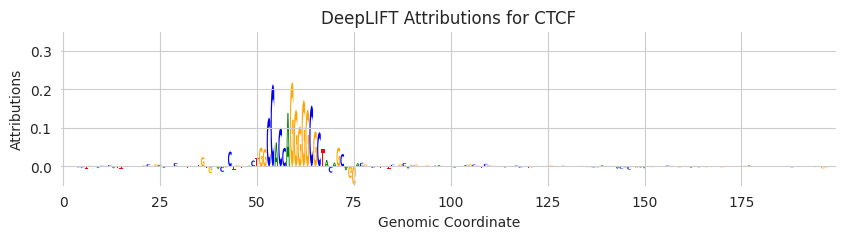

In [12]:
plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0, :, 1000:1200], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("DeepLIFT Attributions for CTCF")
plt.ylim(-0.05, 0.35)
plt.show()

## In silico marginalization

In silico marginalization estimates how much each motif influences the model’s predictions by evaluating its effect across many different background sequences.

[INFO] Model already downloaded: models/BP001194.1_model.h5


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:287: UserWarning: In CPU autocast, but the target dtype is not supported. Disabling autocast.
CPU Autocast only supports dtype of torch.bfloat16, torch.float16 currently.
  warnings.warn(error_message)


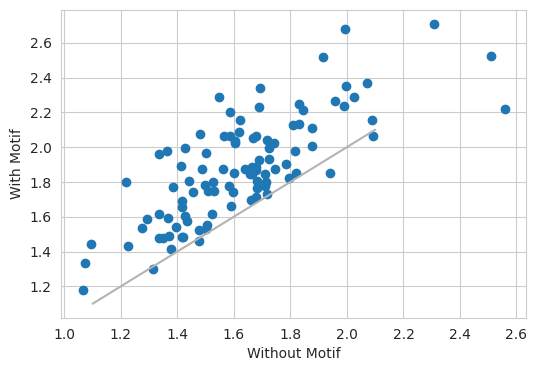

In [13]:
from tangermeme.marginalize import marginalize
X_bg = random_one_hot((100, 4, 2114)).type(torch.float32)  # Generate 100 random sequences with the right size for BPNet to marginalize over
model_path = download_jaspar_model("BP001194.1")
model = BasePairNet.from_bpnet(model_path)
model = ControlWrapper(model)
y_before, y_after = marginalize(model, X_bg, "CTTATCT", args=(torch.zeros(100, 2, 2114),), device='cpu')

plt.figure(figsize=(6, 4))
plt.scatter(y_before[1], y_after[1])
plt.plot([1.1, 2.1], [1.1, 2.1], color='0.7')
plt.xlabel("Without Motif")
plt.ylabel("With Motif")
plt.show()

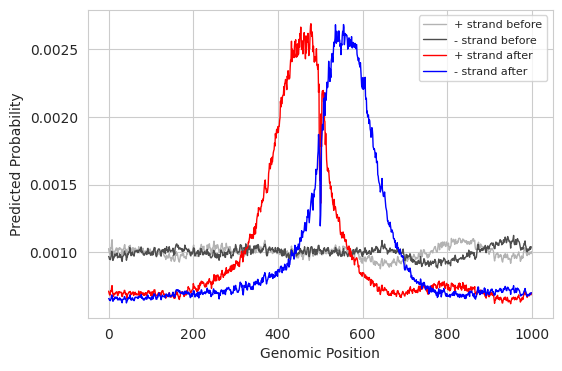

In [14]:
yb = torch.nn.functional.softmax(y_before[0].mean(axis=0), dim=-1)
ya = torch.nn.functional.softmax(y_after[0].mean(axis=0), dim=-1)

plt.figure(figsize=(6, 4))
plt.plot(yb[0], color='0.7', linewidth=1, label="+ strand before")
plt.plot(yb[1], color='0.3', linewidth=1, label="- strand before")

plt.plot(ya[0], color='r', linewidth=1, label="+ strand after")
plt.plot(ya[1], color='b', linewidth=1, label="- strand after")
plt.xlabel("Genomic Position")
plt.ylabel("Predicted Probability")
plt.legend(fontsize=8)
plt.show()

## Variant Effect Prediction
Sequence-based DL models are often used to predict the effects of genetic variants by comparing model predictions on the reference sequence versus the altered one. For instance, if a TF-binding model predicts binding on the reference but not after introducing a variant, the variant may influence phenotype—possibly by disrupting that TF's binding. If the prediction does not change, the variant may have little or no functional impact.

Variants come in several forms. Substitutions are simplest, involving one character replaced by another. Deletions remove characters relative to the reference, while insertions add characters not present in the reference.

Substitution effects are easy to compute because the sequence length stays the same. Insertions and deletions are harder, since they alter sequence length and most DL models require fixed-length inputs. Below, we describe how tangermeme handles each variant type.

We use a GATA2 BPNet model on a sequence that normally contains a GATA motif.

In [15]:
X_ref = random_one_hot((1, 4, 2114), random_state=0).type(torch.float32)
X_ref = substitute(X_ref, "CTTATCT")
model_path = download_jaspar_model("BP001194.1")
model = BasePairNet.from_bpnet(model_path)
model = ControlWrapper(model)

[INFO] Model already downloaded: models/BP001194.1_model.h5


**Substitution**

We’ll modify the GATA motif so that one of the T bases is changed to a C.

In [16]:
from tangermeme.variant_effect import substitution_effect
substitutions = torch.tensor([
    [0, 1058, 0]
])

y, y_var = substitution_effect(model, X_ref, substitutions, args=(torch.zeros(1, 2, 2114),), device='cpu')
len(y), y[0].shape, y[1].shape

(2, torch.Size([1, 2, 1000]), torch.Size([1, 1]))

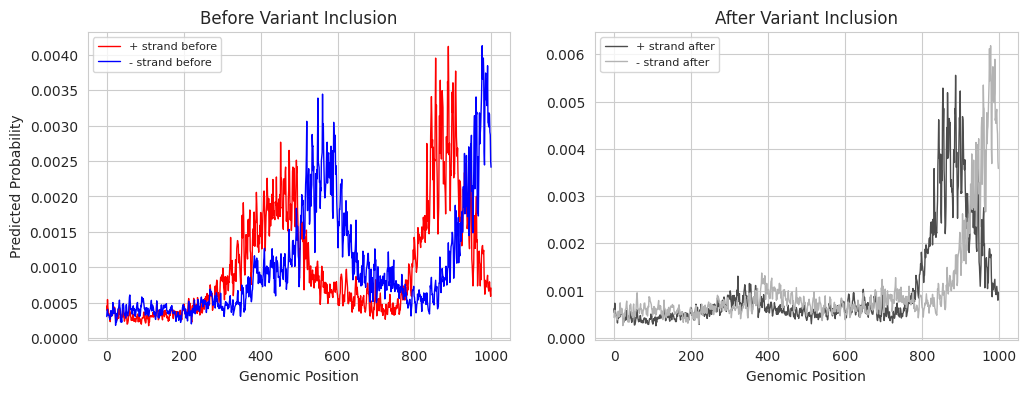

In [17]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

yb = torch.nn.functional.softmax(y[0][0], dim=-1)
ya = torch.nn.functional.softmax(y_var[0][0], dim=-1)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Before Variant Inclusion")
plt.plot(yb[0], color='r', linewidth=1, label="+ strand before")
plt.plot(yb[1], color='b', linewidth=1, label="- strand before")
plt.xlabel("Genomic Position")
plt.ylabel("Predicted Probability")
plt.legend(fontsize=8)

plt.subplot(122)
plt.title("After Variant Inclusion")
plt.plot(ya[0], color='0.3', linewidth=1, label="+ strand after")
plt.plot(ya[1], color='0.7', linewidth=1, label="- strand after")
plt.xlabel("Genomic Position")
plt.legend(fontsize=8)
plt.show()

It appears that the T-to-C change eliminates the predicted signal peak. Such a strong effect from a single nucleotide suggests that this variant could be important and may be worth closer investigation.

**Deletion**

In [18]:
X_ref = random_one_hot((1, 4, 2116), random_state=0).type(torch.float32)
X_ref = substitute(X_ref, "CTTATCT")

In [19]:
deletions = torch.tensor([
    [0, 1],   # Example index 0, delete the character at position 1
    [0, 4]
])
from tangermeme.variant_effect import deletion_effect

y, y_var = deletion_effect(model, X_ref, deletions, device='cpu')
len(y), y[0].shape, y[1].shape

(2, torch.Size([1, 2, 1000]), torch.Size([1, 1]))

**Insertion**

In [20]:
X_ref = random_one_hot((1, 4, 2114), random_state=0).type(torch.float32)
X_ref = substitute(X_ref, "CTTATCT")

In [21]:
insertions = torch.tensor([
    [0, 901, 1],   # Example index 0, insert the character at position 1
    [0, 904, 1]
])

from tangermeme.variant_effect import insertion_effect

y, y_var = insertion_effect(model, X_ref, insertions, device='cpu')
len(y), y[0].shape, y[1].shape

(2, torch.Size([1, 2, 1000]), torch.Size([1, 1]))